# Self-Driving Car Engineer Nanodegree


## Finding Lane Lines on the Road
***

In this project, I used following techniques to find road lane lines:

- Color Selection
- Canny Edge Detection
- Region of Interest Selection
- Hough Transform Line Detection


## Import required packages

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os, glob
from moviepy.editor import VideoFileClip

## Helper method to show images

In [2]:
def display_images(images, cols=2):
    rows = (len(images) + 1) // cols
    
    plt.figure(figsize=(10, 10))
    for idx, image in enumerate(images):
        plt.subplot(rows, cols, idx + 1)

        plt.imshow(image)

        plt.xticks([])
        plt.yticks([])

    plt.show()

## Display original test images

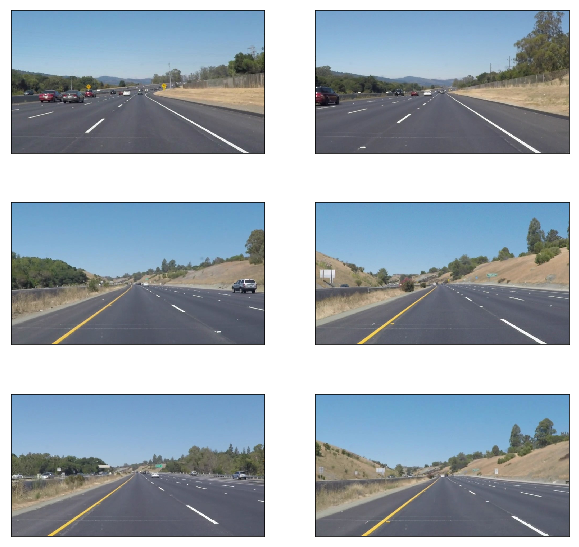

In [3]:
test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]

display_images(test_images)

## Convert to HSV colorspace and apply white and yellow masks

In HSV colorspace, the first dimension refers to HUE. We can specify the range for yellow color.

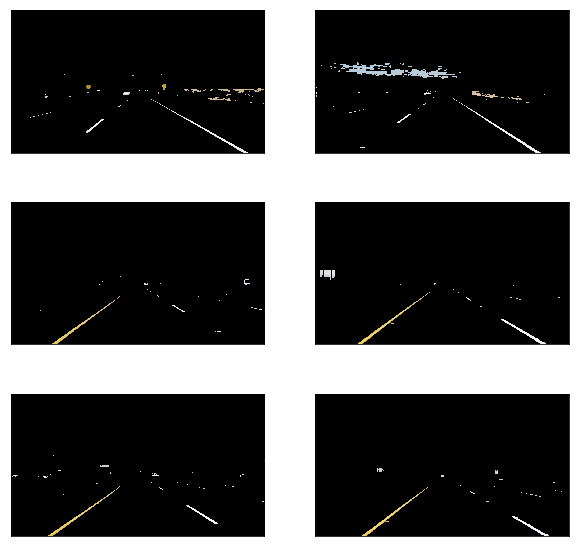

In [4]:
def apply_filter(image):
    converted = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

    white_lower = np.uint8([0, 200,   0])
    white_upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, white_lower, white_upper)

    yellow_lower = np.uint8([10,   0, 100])
    yellow_upper = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(converted, yellow_lower, yellow_upper)

    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask=mask)

filtered_images = list(map(apply_filter, test_images))

display_images(filtered_images)

## Canny Edge Detection

We need to:
- use `cv2.cvtColor` to convert images into gray scale
- use `cv2.GaussianBlur` to smooth out rough edges 

and then:
- use `cv2.Canny` to find edges


### Convert to gray scale

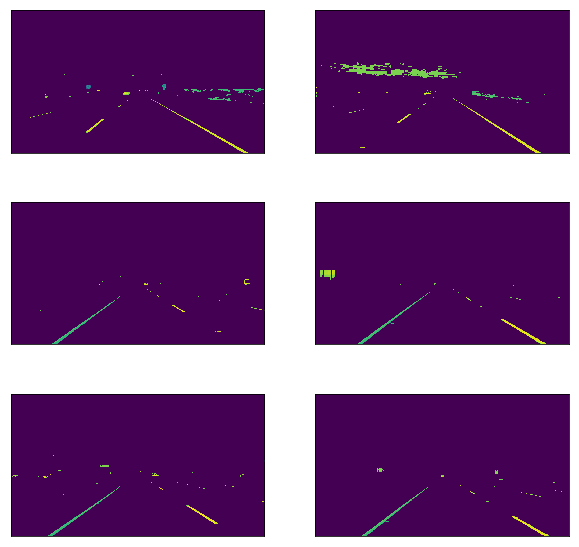

In [5]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gray_scaled_images = list(map(grayscale, filtered_images))

display_images(gray_scaled_images)

### Gaussian Blur

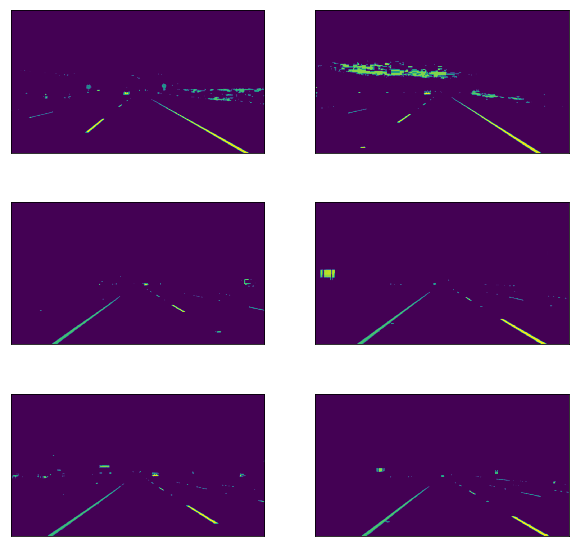

In [6]:
def gaussian_blur(img, kernel_size = 5):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

blurred_images = list(map(gaussian_blur, gray_scaled_images))
display_images(blurred_images)

### Edge Detection

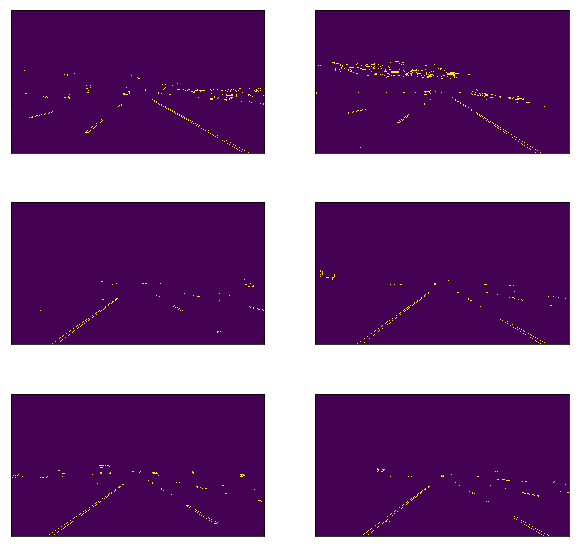

In [7]:
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

images_edges = list(map(lambda image: canny(image, 50, 150), blurred_images))
display_images(images_edges)

## Select Region of Interest

When detecting lane lines, we need to only check the bottom-center triangle.

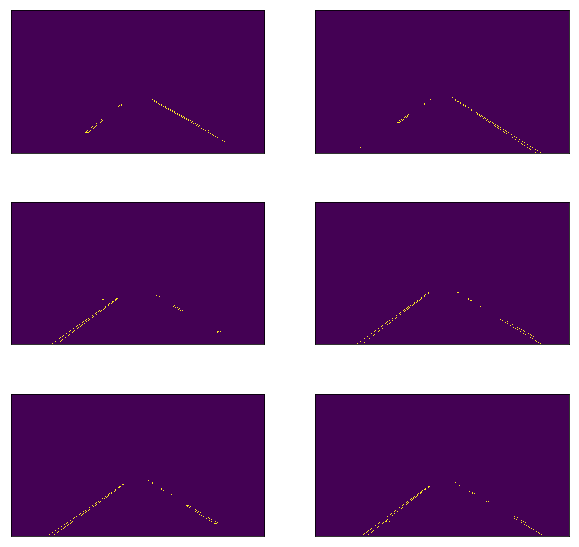

In [8]:
def region_of_interest(img):
    mask = np.zeros_like(img)

    y, x = img.shape[:2]
    bottom_left = [x * 0.1, y]
    top_left = [x * 0.4, y * 0.6]
    bottom_right = [x * 0.9, y]
    top_right = [x * 0.6, y * 0.6]

    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

    ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

cropped_images = list(map(region_of_interest, images_edges))
display_images(cropped_images)

## Hough Transform Line Detection

We use cv2.HoughLinesP to detect lines in the edge images.

In [9]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array(
        []), minLineLength=min_line_len, maxLineGap=max_line_gap)

    return lines

lines = list(map(lambda image: hough_lines(image, 2, np.pi/180, 20, 15, 100), cropped_images))

`lines` contains list of detected lines. We should call this method to draw these lines on image:

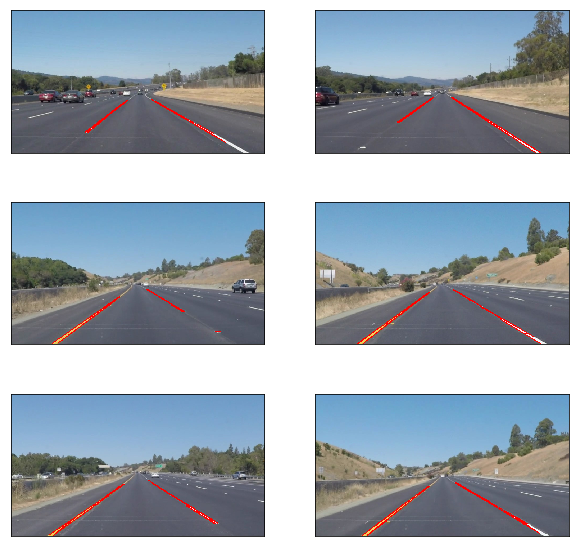

In [10]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    image = np.copy(img)
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image
            
line_images = []
for image, lane_lines in zip(test_images, lines):
    line_images.append(draw_lines(image, lane_lines))
    
display_images(line_images)

## Averaging Lines

There are multiple lines detected for a lane line.  I'm using linear regression come up with an averaged line for that.

In [11]:
def linear_regression(img, lines):
    y, x = img.shape[:2]

    left_x = []
    left_y = []
    right_x = []
    right_y = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 == x1:
                continue
            slope = (y2 - y1) / (x2 - x1)
            if slope > 0.5 and x1 > x/2 and x2 > x/2:
                left_x.append(x1)
                left_x.append(x2)
                left_y.append(y1)
                left_y.append(y2)
            elif slope < -0.5 and x1 < x/2 and x2 < x/2:
                right_x.append(x1)
                right_x.append(x2)
                right_y.append(y1)
                right_y.append(y2)

    left_lane = np.polyfit(left_x, left_y, 1)
    right_lane = np.polyfit(right_x, right_y, 1)

    return left_lane, right_lane

convert the slope and intercept into pixel points:

In [12]:
def line_points(y1, y2, line):
    if line is None:
        return None

    m, b = line

    x1 = int((y1 - b) / m)
    x2 = int((y2 - b) / m)
    y1 = int(y1)
    y2 = int(y2)

    return ((x1, y1), (x2, y2))

draw lane lines:

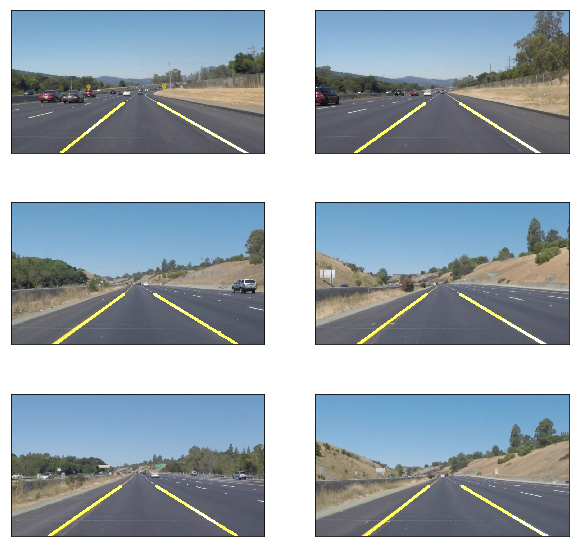

In [13]:
def solid_lane_lines(image, lines):
    left_lane, right_lane = linear_regression(image, lines)

    y1 = image.shape[0]
    y2 = y1 * 0.65

    left_line = line_points(y1, y2, left_lane)
    right_line = line_points(y1, y2, right_lane)

    return left_line, right_line


def draw_lane_lines(image, lines, color=[255, 255, 0], thickness=10):
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    return cv2.addWeighted(image, 1, line_image, 1, 0)


lane_images = []
for image, lane_lines in zip(test_images, lines):
    lane_images.append(draw_lane_lines(image, solid_lane_lines(image, lane_lines)))

    
display_images(lane_images)

## Drawing Lane Lines on video clips

In [14]:
def process_frame(image):
    filtered = apply_filter(image)
    gray_scale = grayscale(filtered)
    blur = gaussian_blur(gray_scale, 5)
    edges = canny(blur, 70, 150)
    cropped = region_of_interest(edges)
    lines = hough_lines(cropped, 2, np.pi / 180, 20, 15, 100)
    left_line, right_line = solid_lane_lines(image, lines)

    return draw_lane_lines(image, (left_line, right_line))


def process_video(file_name):
    clip = VideoFileClip(os.path.join('test_videos', file_name))
    processed = clip.fl_image(process_frame)
    processed.write_videofile(os.path.join(
        'output_videos', file_name), audio=False)

    
process_video('solidWhiteRight.mp4')
process_video('solidYellowLeft.mp4')
process_video('challenge.mp4')

[MoviePy] >>>> Building video output_videos/solidWhiteRight.mp4
[MoviePy] Writing video output_videos/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:03<00:00, 68.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/solidWhiteRight.mp4 

[MoviePy] >>>> Building video output_videos/solidYellowLeft.mp4
[MoviePy] Writing video output_videos/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:09<00:00, 69.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/solidYellowLeft.mp4 

[MoviePy] >>>> Building video output_videos/challenge.mp4
[MoviePy] Writing video output_videos/challenge.mp4


100%|██████████| 251/251 [00:07<00:00, 34.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge.mp4 

